In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import math
from pprint import pprint
from collections import Counter

from sklearn.utils.class_weight import compute_class_weight

tqdm.pandas()

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data_0 = data[data['VAP'] == 0]
data_1 = data[data['VAP'] == 1]

# Count word frequencies in each class
counter_0 = Counter(word for text in data_0['TEXT'] for word in text.split())
counter_1 = Counter(word for text in data_1['TEXT'] for word in text.split())

# Find words that are common to both classes
common_words = set(counter_0.keys()).intersection(counter_1.keys())

# Set the threshold for word removal
threshold = 0.2

# Determine words to remove based on their frequency ratio
words_to_remove = {
    word for word in common_words
    if 1 - threshold <= (counter_1[word] / data_1.shape[0]) / (counter_0[word] / data_0.shape[0]) <= 1 + threshold
}

# Function to remove selected words
def remove_selected_words(text):
    return ' '.join(word for word in text.split() if word not in words_to_remove)

# Apply the function to the 'TEXT' column
data['TEXT'] = data['TEXT'].progress_apply(remove_selected_words)

100%|██████████| 3435/3435 [00:00<00:00, 20027.54it/s]


In [5]:
# remove rows with empty text
data = data[data['TEXT'] != '']

# reindex the DataFrame
data = data.reset_index(drop=True)

<Axes: ylabel='count'>

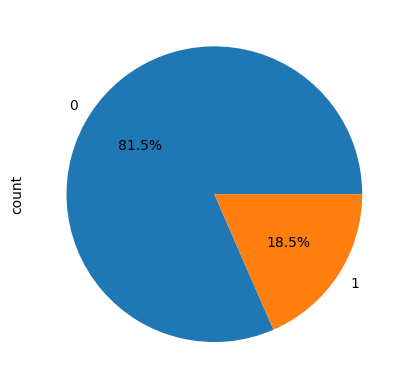

In [6]:
# # create a new dataframe that contains as much data from each class as the number of rows in the class with the least rows
# data_balanced = pd.concat([data[data['VAP'] == 0].sample(data[data['VAP'] == 1].shape[0], random_state=42), data[data['VAP'] == 1]])
# data = data_balanced
# pie chart of Label
data['VAP'].value_counts().plot.pie(autopct='%1.1f%%')

In [7]:
average_words_per_text = data['TEXT'].apply(lambda text: len(text.split())).mean()
print(f'Average words per text: {average_words_per_text}')

# averge words per text class 0
average_words_per_text_class_0 = data[data['VAP'] == 0]['TEXT'].apply(lambda text: len(text.split())).mean()
print(f'Average words per text class 0: {average_words_per_text_class_0}')

# averge words per text class 1
average_words_per_text_class_1 = data[data['VAP'] == 1]['TEXT'].apply(lambda text: len(text.split())).mean()
print(f'Average words per text class 1: {average_words_per_text_class_1}')

Average words per text: 303.671615720524
Average words per text class 0: 299.06604784005714
Average words per text class 1: 324.01892744479494


In [8]:
chunk_size = 1
max_chunks = 350

In [9]:
import gensim

# creating a matrix of word embeddings using the cleaned data and the BioWordVec model
embedding_model = gensim.models.KeyedVectors.load_word2vec_format("bio.bin", binary=True)
embed_dim = embedding_model.vector_size

def split_into_chunks(text, chunk_size=200):
    words = text.split()
    return [' '.join(words[i:i+chunk_size]) for i in range(0, len(words), chunk_size)]

def average_embeddings_for_chunk(chunk, embedding_model):
    embeddings = []
    for word in chunk.split():
        try:
            embeddings.append(embedding_model[word])
        except KeyError:
            
            pass
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(embedding_model.vector_size)  # Return zero vector if no words found

def process_text(text, embedding_model, chunk_size=200, max_chunks=256):
    chunks = split_into_chunks(text, chunk_size)
    chunk_embeddings = [average_embeddings_for_chunk(chunk, embedding_model) for chunk in chunks[:max_chunks]]
    # Pad with zeros if there are fewer chunks than max_chunks
    while len(chunk_embeddings) < max_chunks:
        chunk_embeddings.append(np.zeros(embedding_model.vector_size))
    return chunk_embeddings

# Apply the processing to each row in the DataFrame
chunks_of_embeddings = data['TEXT'].progress_apply(lambda text: process_text(text, embedding_model, chunk_size, max_chunks)).tolist()

100%|██████████| 3435/3435 [00:03<00:00, 880.76it/s]


In [10]:
# split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(chunks_of_embeddings, data['VAP'], test_size=0.3, random_state=42, stratify=data['VAP'])
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)

In [11]:
# Function to convert embeddings and labels to tensors
def embeddings_to_tensor(embeddings):
    return torch.tensor(embeddings, dtype=torch.float32)

# Convert embeddings and labels to tensors
X_train_tensor = embeddings_to_tensor(X_train)
X_val_tensor = embeddings_to_tensor(X_val)
X_test_tensor = embeddings_to_tensor(X_test)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [12]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.5):
        super(TransformerBlock, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
        )
        self.layernorm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, inputs):
        # Permute to [sequence_length, batch_size, hidden_size]
        inputs_perm = inputs.permute(1, 0, 2)
        attn_output, _ = self.att(inputs_perm, inputs_perm, inputs_perm)
        # Back to [batch_size, sequence_length, hidden_size]
        attn_output = attn_output.permute(1, 0, 2)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TextClassificationModel(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, max_seq_len, dropout=0.7, num_transformer_blocks=2):
        super(TextClassificationModel, self).__init__()
        
        # Creating multiple Transformer Blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim)
            for _ in range(num_transformer_blocks)
        ])
        
        # Pooling Layer
        self.pooling = nn.AdaptiveAvgPool1d(1)

        # Additional Linear, BatchNorm, and Dropout Layers
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.batch_norm = nn.BatchNorm1d(embed_dim // 2)
        self.dropout = nn.Dropout(dropout)

        # Final Fully Connected Layer for Classification
        self.fc2 = nn.Linear(embed_dim // 2, 1)
        
        # Positional Encoding Layer
        self.positional_encoding = self.create_positional_encoding(max_seq_len, embed_dim)
    
    
    def forward(self, x):
        seq_len = x.size(1)

        # Get the positional encoding for the sequence length
        scaled_pos_encoding = self.positional_encoding[:seq_len, :]
        scaled_pos_encoding = scaled_pos_encoding.to(x.device)
        scaled_pos_encoding = scaled_pos_encoding.unsqueeze(0).expand(x.size(0), -1, -1)

        # Adding positional encoding
        x = x + scaled_pos_encoding

        # Passing input through each Transformer block sequentially
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        
        # Pooling
        x = x.permute(0, 2, 1)  
        x = self.pooling(x).squeeze(-1)
        
        # Passing through the first linear layer, batch norm, and dropout
        x = F.relu(self.fc1(x))
        x = self.batch_norm(x)
        x = self.dropout(x)

        # Final Classification
        x = self.fc2(x)
        return x

    def create_positional_encoding(self, max_seq_len, embed_dim):
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        positional_encoding = torch.zeros(max_seq_len, embed_dim)
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        return positional_encoding

In [14]:
# define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weights
class_weight = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weight_ratio = class_weight[1] / class_weight[0]
class_weights_tensor = torch.tensor(class_weight_ratio, dtype=torch.float32, device=device)

# Update the loss function to include class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)

In [15]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import json

max_seq_len = max_chunks

epochs = 25

# Define a global variable for the log file
log_file_path = "hyperopt_log.txt"

# Define the objective function
def objective(params):
    with open(log_file_path, "a") as log_file:
        log_file.write(f"Trial params: {json.dumps(params)}\n")
    
    model = TextClassificationModel(
        embed_dim,
        int(params['num_heads']),
        int(params['ff_dim']),
        max_seq_len,
        params['dropout'],
        int(params['num_transformer_blocks'])
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch.float())
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0
        total_val_f1 = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch).squeeze()
                loss = criterion(y_pred, y_batch.float())
                total_val_loss += loss.item()

                y_pred = torch.sigmoid(y_pred)
                y_pred = torch.round(y_pred)
                total_val_accuracy += accuracy_score(y_batch.tolist(), y_pred.tolist())
                total_val_f1 += f1_score(y_batch.tolist(), y_pred.tolist())

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_accuracy = total_val_accuracy / len(val_loader)
        avg_val_f1 = total_val_f1 / len(val_loader)
        
    with open(log_file_path, "a") as log_file:
        log_file.write(f"Loss: {avg_val_loss}\n\n")

    return {'loss': avg_val_loss, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'num_heads': hp.choice('num_heads', [2, 4, 8]),
    'ff_dim': hp.choice('num_heads', [16, 32, 64]),
    'dropout': hp.uniform('dropout', 0.5, 0.9),
    'learning_rate': hp.loguniform('learning_rate', -6, -2),
    'weight_decay': hp.loguniform('weight_decay', -6, -2),
    'num_transformer_blocks': hp.choice('num_transformer_blocks', [1, 2, 3])
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Best Hyperparameters:", best)

In [16]:
num_heads = 8
ff_dim = 64
max_seq_len = max_chunks
dropout = 0.5
num_transformer_blocks = 2
learning_rate = 0.0021
weight_decay = 0.006

epochs = 25


model = TextClassificationModel(embed_dim, num_heads, ff_dim, max_seq_len, dropout, num_transformer_blocks)

# send the model to the device
model = model.to(device)

# Define the optimizer
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay)

model

TextClassificationModel(
  (transformer_blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=200, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=200, bias=True)
      )
      (layernorm1): LayerNorm((200,), eps=1e-06, elementwise_affine=True)
      (layernorm2): LayerNorm((200,), eps=1e-06, elementwise_affine=True)
      (dropout1): Dropout(p=0.2, inplace=False)
      (dropout2): Dropout(p=0.2, inplace=False)
    )
  )
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (batch_norm): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)

In [17]:
print("Using device:", device)

for epoch in range(epochs):
    
    print('-' * 10)
    
    total_train_loss = 0
    total_train_accuracy = 0
    total_train_f1 = 0
    
    model.train()

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    
    for i, batch in progress_bar:
        progress_bar.set_description(f'[Training] Epoch {epoch}]')
        
        optimizer.zero_grad()
        
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_pred = model(X_batch).squeeze() 
        
        loss = criterion(y_pred, y_batch.float())
        
        loss.backward()
        optimizer.step()
        
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)

        total_train_loss += loss.item()
        total_train_accuracy += accuracy_score(y_batch.tolist(), y_pred.detach().cpu().numpy().tolist())
        total_train_f1 += f1_score(y_batch.tolist(), y_pred.detach().cpu().numpy().tolist())
        
        progress_bar.set_postfix({'training_loss': total_train_loss / (i + 1), 'training_accuracy': total_train_accuracy / (i + 1), 'training_f1': total_train_f1 / (i + 1)})
        
    total_val_loss = 0
    total_val_accuracy = 0
    total_val_f1 = 0

    model.eval()
    
    progress_bar = tqdm(enumerate(val_loader), total=len(val_loader))
    
    for i, batch in progress_bar:
        progress_bar.set_description(f'[Validation] Epoch {epoch}]')
        
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        with torch.no_grad():
            y_pred = model(X_batch).squeeze() 
        
        loss = criterion(y_pred, y_batch.float())
        
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)
        
        total_val_loss += loss.item()
        total_val_accuracy += accuracy_score(y_batch.tolist(), y_pred.tolist())
        total_val_f1 += f1_score(y_batch.tolist(), y_pred.tolist())
        
        progress_bar.set_postfix({'validation_loss': total_val_loss / (i + 1), 'validation_accuracy': total_val_accuracy / (i + 1), 'validation_f1': total_val_f1 / (i + 1)})

Using device: cuda
----------


[Validation] Epoch 0]: 100%|██████████| 17/17 [00:00<00:00, 65.19it/s, validation_loss=1.15, validation_accuracy=0.822, validation_f1=0]


----------


[Validation] Epoch 1]: 100%|██████████| 17/17 [00:00<00:00, 63.44it/s, validation_loss=1.06, validation_accuracy=0.523, validation_f1=0.29] 


----------


[Validation] Epoch 2]: 100%|██████████| 17/17 [00:00<00:00, 64.83it/s, validation_loss=1.05, validation_accuracy=0.593, validation_f1=0.361]


----------


[Validation] Epoch 3]: 100%|██████████| 17/17 [00:00<00:00, 65.45it/s, validation_loss=1.02, validation_accuracy=0.77, validation_f1=0.412]  


----------


[Validation] Epoch 4]: 100%|██████████| 17/17 [00:00<00:00, 63.37it/s, validation_loss=0.931, validation_accuracy=0.709, validation_f1=0.461]


----------


[Validation] Epoch 5]: 100%|██████████| 17/17 [00:00<00:00, 66.02it/s, validation_loss=2.49, validation_accuracy=0.825, validation_f1=0]


----------


[Validation] Epoch 6]: 100%|██████████| 17/17 [00:00<00:00, 65.83it/s, validation_loss=0.847, validation_accuracy=0.584, validation_f1=0.429]


----------


[Validation] Epoch 7]: 100%|██████████| 17/17 [00:00<00:00, 65.58it/s, validation_loss=0.749, validation_accuracy=0.868, validation_f1=0.568]


----------


[Validation] Epoch 8]: 100%|██████████| 17/17 [00:00<00:00, 63.60it/s, validation_loss=0.634, validation_accuracy=0.739, validation_f1=0.507]


----------


[Validation] Epoch 9]: 100%|██████████| 17/17 [00:00<00:00, 65.59it/s, validation_loss=2.1, validation_accuracy=0.329, validation_f1=0.333] 


----------


[Validation] Epoch 10]: 100%|██████████| 17/17 [00:00<00:00, 65.12it/s, validation_loss=0.588, validation_accuracy=0.728, validation_f1=0.508]


----------


[Validation] Epoch 11]: 100%|██████████| 17/17 [00:00<00:00, 64.95it/s, validation_loss=0.505, validation_accuracy=0.785, validation_f1=0.552]


----------


[Validation] Epoch 12]: 100%|██████████| 17/17 [00:00<00:00, 65.99it/s, validation_loss=0.636, validation_accuracy=0.69, validation_f1=0.493]


----------


[Validation] Epoch 13]: 100%|██████████| 17/17 [00:00<00:00, 65.10it/s, validation_loss=5.76, validation_accuracy=0.199, validation_f1=0.293]


----------


[Validation] Epoch 14]: 100%|██████████| 17/17 [00:00<00:00, 64.69it/s, validation_loss=1.83, validation_accuracy=0.413, validation_f1=0.356]


----------


[Validation] Epoch 15]: 100%|██████████| 17/17 [00:00<00:00, 64.67it/s, validation_loss=1.1, validation_accuracy=0.886, validation_f1=0.489] 


----------


[Validation] Epoch 16]: 100%|██████████| 17/17 [00:00<00:00, 64.06it/s, validation_loss=1.39, validation_accuracy=0.487, validation_f1=0.387]


----------


[Validation] Epoch 17]: 100%|██████████| 17/17 [00:00<00:00, 64.93it/s, validation_loss=0.411, validation_accuracy=0.818, validation_f1=0.595]


----------


[Validation] Epoch 18]: 100%|██████████| 17/17 [00:00<00:00, 64.86it/s, validation_loss=1.65, validation_accuracy=0.881, validation_f1=0.441]


----------


[Validation] Epoch 19]: 100%|██████████| 17/17 [00:00<00:00, 63.84it/s, validation_loss=0.216, validation_accuracy=0.971, validation_f1=0.856]


----------


[Validation] Epoch 20]: 100%|██████████| 17/17 [00:00<00:00, 65.40it/s, validation_loss=2.09, validation_accuracy=0.847, validation_f1=0.168]


----------


[Validation] Epoch 21]: 100%|██████████| 17/17 [00:00<00:00, 64.05it/s, validation_loss=1.34, validation_accuracy=0.857, validation_f1=0.227]


----------


[Validation] Epoch 22]: 100%|██████████| 17/17 [00:00<00:00, 64.23it/s, validation_loss=6.77, validation_accuracy=0.827, validation_f1=0.0168]


----------


[Validation] Epoch 23]: 100%|██████████| 17/17 [00:00<00:00, 65.23it/s, validation_loss=0.785, validation_accuracy=0.936, validation_f1=0.698]


----------


[Validation] Epoch 24]: 100%|██████████| 17/17 [00:00<00:00, 64.85it/s, validation_loss=0.463, validation_accuracy=0.954, validation_f1=0.777]


Testing: 100%|██████████| 17/17 [00:00<00:00, 64.08it/s, testing_loss=0.615, testing_accuracy=0.939, testing_f1=0.807]


              precision    recall  f1-score   support

           0       0.93      1.00      0.96       421
           1       1.00      0.65      0.79        95

    accuracy                           0.94       516
   macro avg       0.96      0.83      0.88       516
weighted avg       0.94      0.94      0.93       516



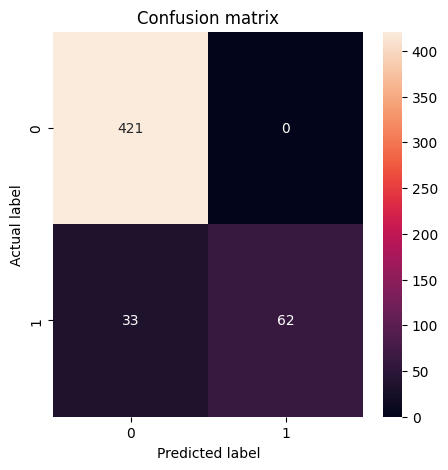

In [18]:
# test the model
model.eval()

total_loss = 0
total_accuracy = 0
total_f1 = 0

all_labels = []
all_predictions = []

progress_bar = tqdm(enumerate(test_loader), total=len(test_loader))

for i, batch in progress_bar:
    progress_bar.set_description(f'Testing')
    
    X_batch, y_batch = batch
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    
    with torch.no_grad():
        y_pred = model(X_batch).squeeze() 
    
    loss = criterion(y_pred, y_batch.float())
    
    y_pred = torch.sigmoid(y_pred)
    y_pred = torch.round(y_pred)
    
    all_labels.extend(y_batch.tolist())
    all_predictions.extend(y_pred.tolist())
    
    total_loss += loss.item()
    total_accuracy += accuracy_score(y_batch.tolist(), y_pred.tolist())
    total_f1 += f1_score(y_batch.tolist(), y_pred.tolist())
    
    progress_bar.set_postfix({'testing_loss': total_loss / (i + 1), 'testing_accuracy': total_accuracy / (i + 1), 'testing_f1': total_f1 / (i + 1)})
    
print(classification_report(all_labels, all_predictions))

# confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()